In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/HerbertMariano/classificacao_genero/master/good_reads_final.csv')

In [3]:
df.drop(columns=['book_fullurl','author_page_url','author_genres','author_name','book_title'],inplace=True)

In [4]:
df['pages'] = np.where(df['pages'] == '1 page', 1, df['pages'])
df['birthplace'] = df['birthplace'].str.replace('\n', '')
df['birthplace'] = df['birthplace'].str.replace(' ', '')
df.publish_date = df.publish_date.str.extract('(^[\d]{1,4})').astype('category')

In [5]:
df['birthplace'] = np.where(df['birthplace'] == '', np.nan, df['birthplace'])
df['birthplace'] = np.where(df['birthplace'] == '  ', np.nan, df['birthplace'])

In [6]:
df['birthplace'] = df['birthplace'].replace(r'^https?:\/\/.*[\r\n]*', np.nan, regex=True)
df.dropna(inplace=True)

In [7]:
encoder = LabelEncoder()

df['author_gender'] = encoder.fit_transform(df['author_gender'])
df['birthplace'] = df['birthplace'].astype('category').cat.codes + 1
df['genre_1'] = df['genre_1'].astype('category').cat.codes + 1
df['genre_2'] = df['genre_2'].astype('category').cat.codes + 1
df['book_id'] = df['book_id'].replace("']", '',regex=True).astype(int)

In [8]:
df

,author_average_rating,author_gender,author_id,author_rating_count,author_review_count,birthplace,book_average_rating,book_id,genre_1,genre_2,num_ratings,num_reviews,pages,publish_date,score
0,4.01,0,74489,74399,6268,180,4.02,686717,60,61,5260,375,277,2000,3230
2,4.00,0,5618190,76496,7975,180,3.99,27833684,81,30,2151,391,354,2016,4585
3,3.88,1,37871,5522,489,33,4.14,382975,38,76,1844,173,438,1970,1533
7,3.94,0,7956,321197,29747,180,3.84,5981308,63,112,45963,4268,319,2008,2054
10,4.39,1,38550,2613993,170695,180,4.28,15704459,36,139,65071,5161,416,2015,4347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22877,3.98,1,2594,26967,1306,180,4.21,15808769,36,111,256,32,304,2013,638
22878,4.36,0,6977170,1682,949,180,4.67,22640224,36,115,21,13,103,2014,751
22884,4.08,0,12020546,569,165,9,4.05,24474924,107,52,155,35,262,2015,1000
22887,4.29,1,7063660,902,428,180,4.56,31429117,81,52,82,57,342,2014,1321


In [9]:
df = df.head(11375)

In [10]:
X = df.drop(columns=['genre_1','genre_2']).values.astype(np.float32)

In [11]:
y = pd.get_dummies(df['genre_1'],dtype=int).values

In [12]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [13]:
class Multiclass(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.act = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.epoch_loss = []
        
    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x
    
    def fit(self, X, y, epochs,batch_size):
        for epoch in range(epochs):
            for i in range(0, len(X), batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                y_pred = self(X_batch)
                loss = self.loss(y_pred, y_batch)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            self.epoch_loss.append(loss.item())

        
    def predict(self, X):
        with torch.no_grad():
            y_pred = self(X)
            _, predicted = torch.max(y_pred.data, 1)
        return predicted

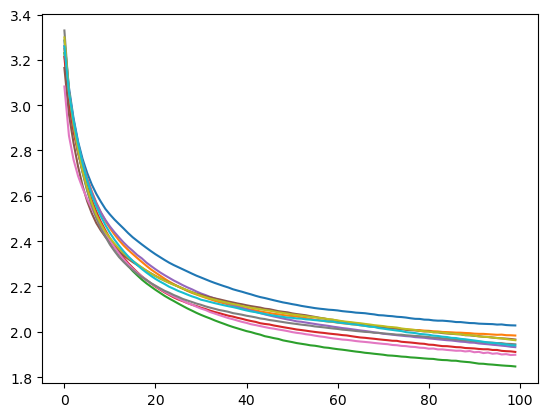

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
lst_accu_stratified = []
batch_size = 64
n_epochs = 100
input_size = X_train.shape[1]
output_size = y_train.shape[1]
hidden_size = 100

for train_fold_index, test_fold_index in kfold.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_fold_index], X_train[test_fold_index]
    y_train_fold, y_test_fold = y_train[train_fold_index], y_train[test_fold_index]
    
    scaler = StandardScaler()
    X_train_fold = torch.from_numpy(scaler.fit_transform(X_train_fold)).float()
    X_test_fold = torch.from_numpy(scaler.transform(X_test_fold)).float()

    model = Multiclass(input_size, hidden_size, output_size)
    model.fit(X_train_fold, y_train_fold, n_epochs, batch_size)
    sns.lineplot(x=range(n_epochs),y=model.epoch_loss)
    y_pred = model.predict(X_test_fold)
    accu = (y_pred == y_test_fold.argmax(1)).float().mean()
    lst_accu_stratified.append(accu.item())